# TP Rossmann - Redes Neuronales

Lucía Ibañez y Albertina Galan

In [89]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary
from tensorflow.keras.utils import to_categorical

In [90]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


In [91]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [92]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

#cat_vars = ['Store', 'DayOfWeek']

In [93]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']

#contin_vars = ['BeforeStateHoliday_bool', 'Max_TemperatureC']

In [94]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]
uniques.T

,uniques
Store,1115
DayOfWeek,7
Year,3
Month,12
Day,31
StateHoliday,4
CompetitionMonthsOpen,25
Promo2Weeks,26
StoreType,4
Assortment,3


# Asignación de dimensión de embeddings

In [95]:
cat_var_dict = {
    'Store': 1115, 
    'DayOfWeek': 7, 
    'Year': 3, 
    'Month': 12,
    'Day': 31, 
    'StateHoliday': 4, 
    'CompetitionMonthsOpen': 25,
    'Promo2Weeks': 26,
    'StoreType': 4,
    'Assortment': 3,
    'PromoInterval': 4,
    'CompetitionOpenSinceYear': 21,
    'Promo2SinceYear': 8, 
    'State': 12,
    'Week': 52,
    'Events': 22,
    'Promo_fw': 6,
    'Promo_bw': 6,
    'StateHoliday_bool_fw': 3,
    'StateHoliday_bool_bw': 3,
    'SchoolHoliday_fw': 8,
    'SchoolHoliday_bw': 8}

In [96]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print()

Store 1115 1115 [   0    1    2 ... 1112 1113 1114]

DayOfWeek 7 7 [0 1 2 3 4 5 6]

Year 3 3 [0 1 2]

Month 12 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Day 31 31 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]

StateHoliday 4 4 [0 1 2 3]

CompetitionMonthsOpen 25 25 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]

Promo2Weeks 26 26 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]

StoreType 4 4 [0 1 2 3]

Assortment 3 3 [0 1 2]

PromoInterval 4 4 [0 1 2 3]

CompetitionOpenSinceYear 21 21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]

Promo2SinceYear 8 8 [0 1 2 3 4 5 6 7]

State 12 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Week 52 52 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]

Events 22 22 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 

# Definición de modelo

In [97]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2

In [98]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [99]:
add_customers = True
log_output = True
output_activation = 'linear'
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

In [100]:
# Descomentar para ver resultados
# cat_vars_embed_outs
# cat_var_inputs
# cont_vars_inputs
# cont_vars_outs

## Modelo implementado

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

**Pruebas**

Probamos el baseline para saber como funcionaba y a partir de ahi fuimos probando sacar la regularizacion L2, poner maxNorm, inicializar con distribucion normal en vez de uniforme, poner batch normalization, poner más capas, cambiar la cantidad de neuronas en cada capa, poner dropout, y varias combinaciones de todo eso. 

El mejor resultado obtenido fue con constrain MaxNorm(6), inicializando con distribucion normal de desviación estandar 0.15, y con regularizacion L2. Se hicieron 3 capas, usando batch normalization y dropout. 

A continuacion se puede ver la red que mejor performance tuvo.

Las performances de las distintas combinaciones fueron muy similares, rondando entre 0.16 y 0.12 el private score y entre 0.15 y 0.21 el public. No hubo alguna combinación que tuviera una performance muy notoriamente mejor o peor. 

Con más y menos neuronas fue ligeramente peor el resultado. Lo mismo al poner LeakyReLu. Poniendo más capas también empeoró un poco.

In [102]:
l2_lambda = 1e-4
merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)

x = Dense(1000, kernel_constraint=MaxNorm(6), kernel_initializer=initializers.RandomNormal(stddev=0.15), kernel_regularizer=l2(l2_lambda))(merged)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

x = Dense(500, kernel_constraint=MaxNorm(6))(merged)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

x = Dense(1000, kernel_constraint=MaxNorm(6), kernel_initializer=initializers.RandomNormal(stddev=0.15), kernel_regularizer=l2(l2_lambda))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

output_1 = Dense(1, name='Sales', activation=output_activation)(x)
output_2 = Dense(1, name='Customers', activation=output_activation)(x)

In [103]:
if add_customers:
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
else: 
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1])

In [104]:
# Descomentar para ver
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Store_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DayOfWeek_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Year_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Month_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Day_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ StateHoliday_input  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CompetitionMonthsO… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Promo2Weeks_input   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ StoreType_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Assortment_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PromoInterval_input │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CompetitionOpenSin… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Promo2SinceYear_in… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ State_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Week_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Events_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Promo_fw_input      │ (None, 1)         │          0 │ -               

 Total params: 2,457,803 (9.38 MB)

 Trainable params: 2,455,803 (9.37 MB)

 Non-trainable params: 2,000 (7.81 KB)

In [105]:
model.save_weights('initial.weights.h5')

In [106]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [107]:
stores_mean = {}
for store, g_df in df_train.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [108]:
df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)

df_train.loc[:, 'Sales_store'] = df_train['Sales'] - df_train['mean_by_store']
df_val.loc[:, 'Sales_store'] = df_val['Sales'] - df_val['mean_by_store']

C:\Users\Albertina Galan\AppData\Local\Temp\ipykernel_2960\3553976367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
C:\Users\Albertina Galan\AppData\Local\Temp\ipykernel_2960\3553976367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)
C:\Users\Albertina Galan\AppData\Local\Temp\ipykernel_2960\3553976367.py:4: SettingWithCopyWarning: 
A value is trying t

In [109]:
from tensorflow.keras import backend as K

In [110]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [111]:
def get_metric(df, sales_):
    return np.sqrt((((df['Sales'] - sales_)/df['Sales'])**2).mean())
get_metric(df_val, df_val['mean_by_store'])

0.3071746085338871

In [112]:
all_vars = cat_vars + contin_vars
X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

In [113]:
if add_customers:
    y_out_columns = ['Sales', 'Customers']
else:
    y_out_columns = ['Sales_store']
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns].values))
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    y_mean = df_train[y_out_columns].mean().values
    y_std = df_train[y_out_columns].std().values
    #y_train = (df_train[y_out_columns].values - y_mean)/y_std
    #y_val = (df_val[y_out_columns].values - y_mean)/y_std
    y_max = df_train[y_out_columns].max().values
    y_train = df_train[y_out_columns].values/y_max
    y_val = df_val[y_out_columns].values/y_max
y_train = np.hsplit(y_train, y_train.shape[1])
y_val = np.hsplit(y_val, y_val.shape[1])

In [114]:
lr = 0.0001
model.compile(optimizer=Adam(learning_rate=lr), metrics=['mse', rmspe], loss='mse')

In [115]:
if add_customers:
    checkpoint = ModelCheckpoint('bestmodel.keras', monitor='val_Sales_mse', verbose=1, save_best_only=True)
else:
    checkpoint = ModelCheckpoint('bestmodel.keras', monitor='val_loss', verbose=1, save_best_only=True)

In [116]:
rlrop = ReduceLROnPlateau(
    monitor = "val_Sales_mse",
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 1e-5
)

In [117]:
es = EarlyStopping(
    monitor = "val_Sales_mse",
    patience = 7, 
    verbose = 1,
    restore_best_weights = True,
    mode='min',
)

In [118]:
epochs = 35
batch_size = 128
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),  
    epochs=epochs, 
    batch_size=batch_size, 
    callbacks=[rlrop, es, checkpoint], 
    verbose=2
)

Epoch 1/35


c:\Users\Albertina Galan\Python\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Store_input', 'DayOfWeek_input', 'Year_input', 'Month_input', 'Day_input', 'StateHoliday_input', 'CompetitionMonthsOpen_input', 'Promo2Weeks_input', 'StoreType_input', 'Assortment_input', 'PromoInterval_input', 'CompetitionOpenSinceYear_input', 'Promo2SinceYear_input', 'State_input', 'Week_input', 'Events_input', 'Promo_fw_input', 'Promo_bw_input', 'StateHoliday_bool_fw_input', 'StateHoliday_bool_bw_input', 'SchoolHoliday_fw_input', 'SchoolHoliday_bw_input', 'CompetitionDistance_input', 'Max_TemperatureC_input', 'Mean_TemperatureC_input', 'Min_TemperatureC_input', 'Precipitationmm_input', 'Max_Humidity_input', 'Mean_Humidity_input', 'Min_Humidity_input', 'Max_Wind_SpeedKm_h_input', 'Mean_Wind_SpeedKm_h_input', 'CloudCover_input', 'trend_input', 'trend_DE_input', 'AfterStateHoliday_bool_input', 'BeforeStateHoliday_


Epoch 1: val_Sales_mse improved from inf to 0.00316, saving model to bestmodel.keras
6361/6361 - 141s - 22ms/step - Customers_loss: 0.0506 - Customers_rmspe: 0.3030 - Sales_loss: 0.0834 - Sales_mse: 0.0834 - loss: 1.0151 - val_Customers_loss: 0.0020 - val_Customers_rmspe: 0.0704 - val_Sales_loss: 0.0032 - val_Sales_mse: 0.0032 - val_loss: 0.5125 - learning_rate: 1.0000e-04
Epoch 2/35

Epoch 2: val_Sales_mse improved from 0.00316 to 0.00168, saving model to bestmodel.keras
6361/6361 - 139s - 22ms/step - Customers_loss: 0.0011 - Customers_rmspe: 0.0538 - Sales_loss: 0.0022 - Sales_mse: 0.0022 - loss: 0.1606 - val_Customers_loss: 9.0048e-04 - val_Customers_rmspe: 0.0475 - val_Sales_loss: 0.0017 - val_Sales_mse: 0.0017 - val_loss: 0.0104 - learning_rate: 1.0000e-04
Epoch 3/35

Epoch 3: val_Sales_mse improved from 0.00168 to 0.00118, saving model to bestmodel.keras
6361/6361 - 128s - 20ms/step - Customers_loss: 5.7430e-04 - Customers_rmspe: 0.0390 - Sales_loss: 0.0010 - Sales_mse: 0.0010 -

In [119]:
import matplotlib.pyplot as plt

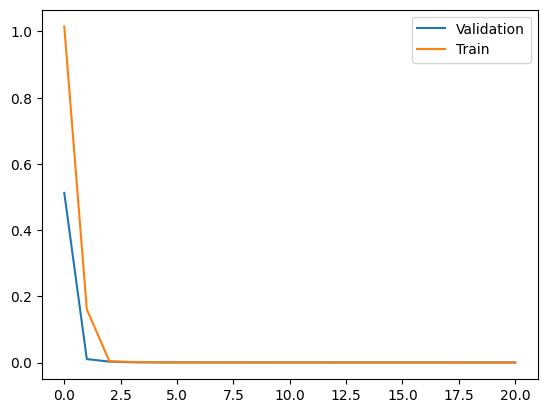

In [120]:
plt.plot(history.history["val_loss"], label='Validation')
# plt.plot(history.history['val_Customers_mse'])
# plt.plot(history.history['val_Sales_mse'])
#plt.show()
plt.plot(history.history["loss"], label='Train')
# plt.plot(history.history['Customers_mse'])
# plt.plot(history.history['Sales_mse'])
plt.legend()
plt.show()

# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [121]:
model.evaluate(X_val, y_val)

944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Customers_loss: 8.9277e-05 - Customers_rmspe: 0.0150 - Sales_loss: 1.2184e-04 - Sales_mse: 1.2184e-04 - loss: 2.1927e-04


[0.00020189565839245915,
 0.00011167563934577629,
 8.22680740384385e-05,
 0.014477885328233242,
 0.00011151163198519498]

In [122]:
model.load_weights('bestmodel.keras')
model.evaluate(X_val, y_val)

944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Customers_loss: 8.9277e-05 - Customers_rmspe: 0.0150 - Sales_loss: 1.2184e-04 - Sales_mse: 1.2184e-04 - loss: 2.1927e-04


[0.00020189565839245915,
 0.00011167563934577629,
 8.22680740384385e-05,
 0.014477885328233242,
 0.00011151163198519498]

In [123]:
if log_output:
    if add_customers:
        y_pred = np.exp(model.predict(X_val, verbose=1)[0][:, 0]*max_log_y)
        y_pred_test = np.exp(model.predict(X_test, verbose=1)[0][:, 0]*max_log_y)
    else:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)[:,0]
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)[:,0]
else:
    if add_customers:
        y_pred = (model.predict(X_val, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
        y_pred_test = (model.predict(X_test, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
    else:
        #y_pred = model.predict(X_val, verbose=1)[:,0]*y_std + y_mean
        #y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_std + y_mean
        y_pred = model.predict(X_val, verbose=1)[:,0]*y_max
        y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_max
y_pred_test[df_test['Open'] == 0] = 0

944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
1284/1284 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


In [124]:
np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))

0.11905013819303624

In [125]:
y_pred_test[:10]

array([4137.3755, 6727.7065, 8290.838 , 6523.665 , 6723.673 , 5432.232 ,
       6732.887 , 7524.4136, 4511.387 , 5268.8516], dtype=float32)

# Sumbit a la competición

In [126]:
import pandas as pd

In [127]:
sample_csv = pd.read_csv('rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision.csv', index=False)

# Analisis de embedings

In [128]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

(7, 7)


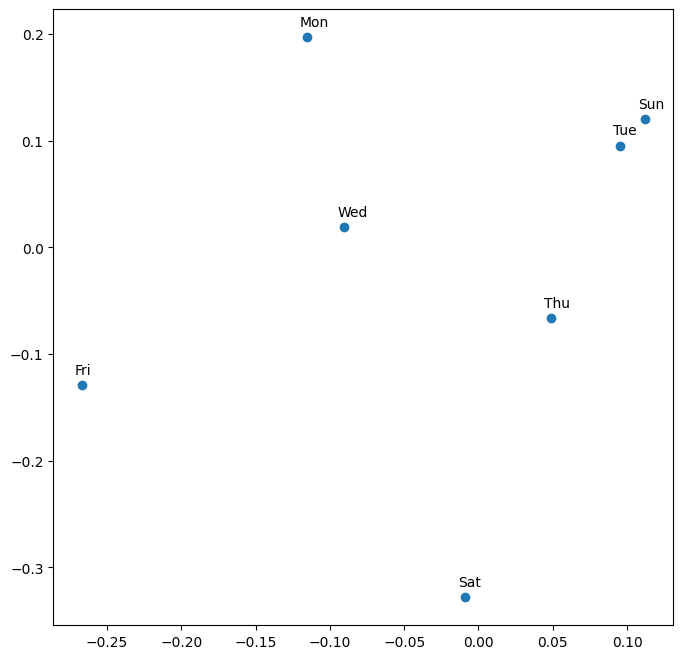

In [129]:
model.load_weights('bestmodel.keras')
plot_embed('DayOfWeek_Embed', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

(12, 12)


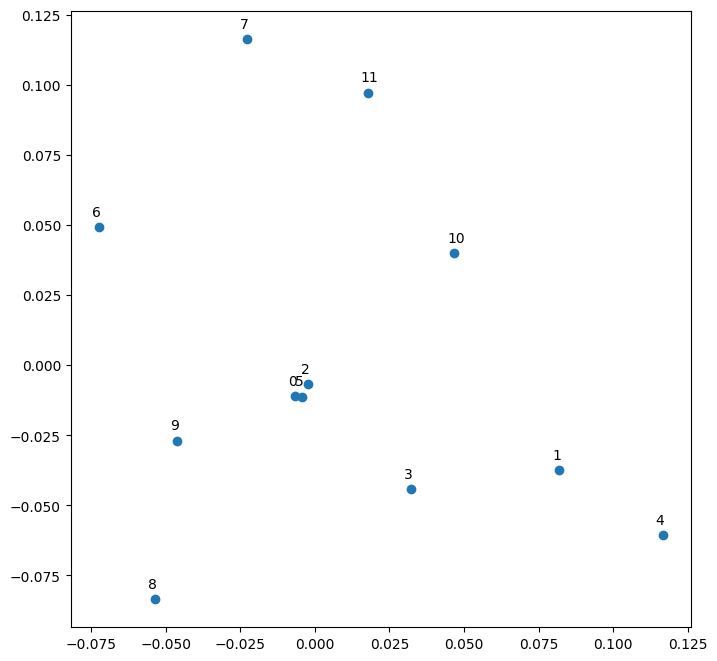

In [130]:
plot_embed('Month_Embed', list(range(12)))

In [131]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [132]:
#day_of_week_embedding.shape

In [133]:
'''tsne = TSNE(n_components=2, random_state=1, learning_rate=10, n_iter=10000)
Y = tsne.fit_transform(day_of_week_embedding)
names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')'''

"tsne = TSNE(n_components=2, random_state=1, learning_rate=10, n_iter=10000)\nY = tsne.fit_transform(day_of_week_embedding)\nnames = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']\nplt.figure(figsize=(8,8))\nplt.scatter(-Y[:, 0], -Y[:, 1])\nfor i, txt in enumerate(names):\n    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')"

In [134]:
cat_vars

['Store',
 'DayOfWeek',
 'Year',
 'Month',
 'Day',
 'StateHoliday',
 'CompetitionMonthsOpen',
 'Promo2Weeks',
 'StoreType',
 'Assortment',
 'PromoInterval',
 'CompetitionOpenSinceYear',
 'Promo2SinceYear',
 'State',
 'Week',
 'Events',
 'Promo_fw',
 'Promo_bw',
 'StateHoliday_bool_fw',
 'StateHoliday_bool_bw',
 'SchoolHoliday_fw',
 'SchoolHoliday_bw']

In [135]:
submodel = Model(cat_var_inputs + cont_vars_inputs, merged)

In [136]:
submodel.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Store_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DayOfWeek_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Year_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Month_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Day_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ StateHoliday_input  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CompetitionMonthsO… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Promo2Weeks_input   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ StoreType_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Assortment_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PromoInterval_input │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CompetitionOpenSin… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Promo2SinceYear_in… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ State_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Week_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Events_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Promo_fw_input      │ (None, 1)         │          0 │ -               

 Total params: 1,249,801 (4.77 MB)

 Trainable params: 1,249,801 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

In [137]:
submodel.save('embeddings_model.hdf5')